In [1]:
from matplotlib.colors import ListedColormap # for grgphing decision boundaries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split

In [2]:
data_folder = 'data'
X_train = pd.read_csv(f'./{data_folder}/X_train.csv')
y_train = pd.read_csv(f'./{data_folder}/y_train.csv')
X_test = pd.read_csv(f'./{data_folder}/X_test.csv')
y_test = pd.read_csv(f'./{data_folder}/y_test.csv')

In [3]:
class Network:
    def __init__(self):
        # layers/activations
        self.input = np.random.rand(4, 1)
        self.h1 = np.random.rand(2, 1)
        self.h2 = np.random.rand(3, 1)
        
        # weights 
        self.w_1 = np.random.rand(2, 4)
        self.w_2 = np.random.rand(3, 2)
        
        # biases 
        self.b_1 = np.random.rand(2, 1)
        self.b_2 = np.random.rand(3, 1)

        
    def one_hot(self,y):
        one_hot_y = np.zeros((y.size, y.max()+1))
        one_hot_y[np.range(y,size), y] = 1
        return one_hot_y.T

    def relu(self,activations):
        return np.maximum(0, activations)

    def relu_deriv(self, activations):
        return activations > 0

    def softmax(self, activations):
        return np.exp(activations) / np.sum(np.exp(activations))
    
    def feed_forward(self, X):
        # input
        # reshapre the input into vector form.
        # Example [1, 0, 0] -> [[1], [1], [1]]
        self.input = np.reshape(X, (-1,1))
        
        # input -> h1
        # the activations in the first hidden layer are given by the dot product 
        # of the weights by the input plus some biass its all then passed into
        # our activation function. relu(W_1*x+b_1)
        h1_activations = self.relu(np.dot(self.w_1, self.input) + self.b_1)
        self.h1 = h1_activations

        # h1 -> h2
        # the activations in the seocnd hidden layer (h_2) are given by the dot product 
        # of the second weights (w_2) by the previous activations (h1) plus the bias(b_2).
        # W_2*h1+b_2
        h2_activations = (np.dot(self.w_2, h1_activations) + self.b_2)
        self.h2 = h2_activations 

        # h2 -> output 
        # our output activtions/predictions are given by the second layer activations (h_2)
        # put into the softmax function. 
        output = self.softmax(self.h2)
        
        return (output, max(output))
    
    def back_prop(self, output, y, learning_rate=0.01):
        y = np.reshape(y, (-1,1))
#         print(input_)
        
        # Derivative of the cost function.
        # The cost function is C = (output - y)^2
        # The derivative of that is 2 (output - y)
        dc = (2 * (output - y))
        
        # Derivative of the cost function with respect to the weights (w_2).
        # The because our output is given by: output = w_2*h_1+b_2. The deriative
        # of the cost function with respect to w_2 is: dc * h1
        dc_dw2 = -learning_rate * dc.dot(self.h1.T)
        b_2 = -learning_rate * dc


        # Derivative of the cost function with respect to the first weights (w_1)
        # h1 is given by w_1*x+b_1
        h1_error = self.w_2.T.dot(dc) * self.relu_deriv(self.h1)
        dc_dw1 = -learning_rate * (h1_error.dot(self.input.T))
        b_1 = -learning_rate * h1_error
        
        # update all the weights
        self.w_1 +=  dc_dw1
        self.w_2 +=  dc_dw2
        
        # update all the biases
        self.b_1 += b_1
        self.b_2 += b_2
        return 0
       
    def get_accuracy(self, data):
        total = 0
        error = 0
        mse = 0
        for index, row in data.iterrows():
            # select the label
            y = row.tolist()[4:]
            # select the x
            X = row.tolist()[:4] 
            output, predicted = self.feed_forward(X)
            label_index = y.index(max(y))
            predicted_index = np.where(output==predicted)[0][0]
            if label_index == predicted_index:
                total += 1
            error += (error, (np.reshape(y, (-1,1))**2))
        return total/data.shape[0]
        

    def train(self, X, Y, itterations):        
        y_dummies = pd.get_dummies(Y)
        data = pd.concat([X, y_dummies], axis=1)
        mse = 0
        error = 0
        for i in range(itterations):
            iteration = i
            total = 0
            for index, row in data.iterrows():
                # select the label
                y = row.tolist()[4:]
                # select the x
                x = row.tolist()[:4] 
                # feed forward
                output, predicted = self.feed_forward(x)
                # back prop
                self.back_prop(output, y)
                # check if its a correct answer
                label_index = y.index(max(y))
                predicted_index = np.where(output==predicted)[0][0]
                if label_index == predicted_index:
                    total += 1
                # add to the error
                error += (error, (np.reshape(y, (-1,1))**2)) 
        training_accuracy = self.get_accuracy(data)
        mse = error/data.shape[0]
        return training_accuracy, mse

In [4]:
data = pd.concat([X_test, pd.get_dummies(y_test)], axis=1)

In [5]:
nn = Network()

In [6]:
nn.train(X_train, y_train, 100)

0.9732142857142857

In [7]:
print(f'Test Accuracy: {nn.get_accuracy(data)}')

Test Accuracy: 0.9210526315789473


In [8]:
# TODO: add confusion matrix to show how the network is classifying things

In [9]:
def get_info(iterations, X_train, y_train, test_data):
    """
    This function will return data to graph how our neural network
    changes as we increas the iterations. 
    """
    df = pd.DataFrame(columns=['iteration', 'training_accuracy', 'tetst_accuracy'])
    for i in iterations:
        # create a new network
        network = Network()
        # train our network (also return trainin accuracy)
        training_accuracy = network.train(X_train, y_train, i)
        # returns test accuracy
        test_accuracy = network.get_accuracy(test_data)
        # add to df
        df.loc[i] = [i] + [training_accuracy] + [test_accuracy]
    return df

In [13]:
nums = [5, 10, 50, 100, 300, 600, 900, 1200, 1500, 1800, 2100, 2400, 2700, 3000, 3300]
df = get_info(nums, X_train, y_train, data)

In [14]:
df

,iteration,training_accuracy,tetst_accuracy
5,5.0,0.732143,0.684211
10,10.0,0.821429,0.789474
50,50.0,0.946429,0.921053
100,100.0,0.973214,0.921053
300,300.0,0.973214,0.947368
600,600.0,0.973214,0.947368
900,900.0,0.973214,0.947368
1200,1200.0,0.973214,0.947368
1500,1500.0,0.973214,0.947368
1800,1800.0,0.982143,0.947368


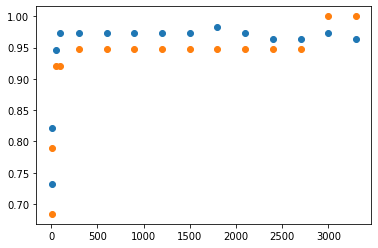

In [18]:
# TODO: graph this with the lost as iterations
plt.scatter(df['iteration'], df['training_accuracy'])
plt.scatter(df['iteration'], df['tetst_accuracy'])
plt.show()